In [57]:
from pathlib import Path
import os

# Establece la raíz del proyecto manualmente
project_root = Path("F:/JCMDataCenter/Cursos/Evolve Academy/Data Scientist IA/Futpeak") # sobremesa
#project_root = Path("C:/Users/juanm/Desktop/FUTPEAK/Futpeak") # portátil

# Cambia el directorio de trabajo actual a esa raíz
os.chdir(project_root)

print("📁 Directorio de trabajo actual:", Path.cwd())

📁 Directorio de trabajo actual: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Futpeak


# ETAPA 1 — Carga y exploración de los datos

En esta primera etapa, cargamos los archivos `matchlogs` y `metadata`, que contienen información por partido y por jugador, respectivamente.

Nuestro objetivo aquí no es solo cargar los datos, sino **entender qué columnas hay, qué tipo de variables contiene cada una, y cuáles vamos a usar o descartar**.

### ¿Qué buscamos al explorar?
- Qué columnas tienen valores nulos
- Qué columnas son categóricas, numéricas o de fecha
- Si hay identificadores únicos (`Player_ID`)
- Qué variables nos pueden servir para el modelo

Vamos a centrarnos en **variables relacionadas con el rendimiento en el campo**, y **descartar muchas otras que no aportan directamente al objetivo de predecir la evolución del jugador**.



In [58]:
import pandas as pd

# Load datasets
df_matchlogs = pd.read_csv("data/processed/cleaned_matchlogs.csv")
df_metadata = pd.read_csv("data/processed/cleaned_metadata.csv")

# Show general info for structure
print("🔍 Matchlogs structure:")
df_matchlogs.info()

print("\n🧾 Metadata structure:")
df_metadata.info()

# Preview a few rows
df_matchlogs.head()


🔍 Matchlogs structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368257 entries, 0 to 368256
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Player_name            368257 non-null  object 
 1   Player_ID              368257 non-null  object 
 2   Seasons                368257 non-null  object 
 3   Date                   368257 non-null  object 
 4   Day                    368257 non-null  object 
 5   Competition            368257 non-null  object 
 6   Round                  368257 non-null  object 
 7   Home_Away              368257 non-null  object 
 8   Result                 368257 non-null  object 
 9   Player_team            368257 non-null  object 
 10  Rival_team             368257 non-null  object 
 11  Start                  368257 non-null  object 
 12  Position               283886 non-null  object 
 13  Minutes                367852 non-null  float64
 14  Goals        

,Player_name,Player_ID,Seasons,Date,Day,Competition,Round,Home_Away,Result,Player_team,...,x_assisted_G,Shot_creating_actions,Goal_creating_actions,Passes_completed,Passes_att,Percent_passes,Progressive_passes,Feet_control,Progressive_control,Dribling_suc
0,Luciano Abecasis,6c510f2d,2016,2016-02-05,Fri,Primera Div,Matchweek 1,Away,L 0–1,Godoy Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Luciano Abecasis,6c510f2d,2016,2016-02-12,Fri,Primera Div,Matchweek 2,Home,D 1–1,Godoy Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Luciano Abecasis,6c510f2d,2016,2016-02-18,Thu,Primera Div,Matchweek 3,Away,W 2–1,Godoy Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Luciano Abecasis,6c510f2d,2016,2016-02-21,Sun,Primera Div,Matchweek 4,Home,W 4–1,Godoy Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Luciano Abecasis,6c510f2d,2016,2016-02-26,Fri,Primera Div,Matchweek 5,Away,W 3–2,Godoy Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# View all columns in matchlogs
print("🔧 All columns in matchlogs:")
print(df_matchlogs.columns.tolist())

# List of columns we plan to keep
columns_to_use = [
    'Player_ID', 'Date', 'Minutes', 'Goals', 'Assists',
    'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards'
]

print("\n✅ Columns selected for modeling:")
print(columns_to_use)

# Optional: create a reduced version of the matchlogs
df_matchlogs = df_matchlogs[columns_to_use]



🔧 All columns in matchlogs:
['Player_name', 'Player_ID', 'Seasons', 'Date', 'Day', 'Competition', 'Round', 'Home_Away', 'Result', 'Player_team', 'Rival_team', 'Start', 'Position', 'Minutes', 'Goals', 'Assists', 'Penalty_kick', 'Penalty_kick_att', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Fouls_committed', 'Fouls_drawn', 'Offsides', 'Crosses', 'Tackles_won', 'Interceptions', 'Own_goals', 'Penaltys_won', 'Penaltys_conceded', 'Touches', 'Tackles', 'Blocks', 'xG', 'non_penalty_xG', 'x_assisted_G', 'Shot_creating_actions', 'Goal_creating_actions', 'Passes_completed', 'Passes_att', 'Percent_passes', 'Progressive_passes', 'Feet_control', 'Progressive_control', 'Dribling_suc']

✅ Columns selected for modeling:
['Player_ID', 'Date', 'Minutes', 'Goals', 'Assists', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards']


# ETAPA 2 — Filtrado de jugadores ofensivos y cálculo del debut

No todos los jugadores tienen el mismo tipo de rendimiento ni las mismas estadísticas.  
En este proyecto, **nos centramos en jugadores ofensivos y mediocampistas**, porque son los que aportan goles, asistencias y tiros (las métricas que usaremos para valorar el rendimiento).

Además, para poder analizar la progresión desde el inicio de la carrera, necesitamos:
- Detectar el **primer partido profesional (debut)**.
- Calcular desde entonces en qué año de carrera está cada jugador en cada partido.

También calcularemos la edad del jugador en cada partido, porque **la edad es una variable predictiva clave** para el tipo de evolución que tendrá.


In [60]:
POSITION_GROUPS = {
    'GOALKEEPER': ['GK'],

    'DEFENSIVE': [
        'CB',    # Center Back
        'LB',    # Left Back
        'RB',    # Right Back
        'FB',    # Fullback
        'LWB',   # Left Wing Back
        'RWB',   # Right Wing Back
        'SW',    # Sweeper
        'D'      # Generic Defender
    ],

    'MIDFIELD': [
        'CM',    # Center Midfielder
        'DM',    # Defensive Midfielder
        'MF',     # Generic Midfielder
        'AM'     # Attacking Midfielder (can also be attacking, but here consider control of juego)
    ],

    'ATTACKING': [
        'CF',    # Center Forward
        'ST',    # Striker
        'F',     # Generic Forward
        'FW',    # Forward (alternative code)
        'LW',    # Left Wing
        'RW',    # Right Wing
        'WF',    # Wing Forward
        'IF',    # Inside Forward
        'OL',    # Outside Left
        'OR'     # Outside Right
    ]
}


In [61]:
# Define relevant positions for attacking/midfield players
target_positions = POSITION_GROUPS['MIDFIELD'] + POSITION_GROUPS['ATTACKING']

# Create a function to check if position is relevant
def is_target_position(pos):
    if pd.isna(pos):
        return False
    return any(p in pos.split('-') for p in target_positions)

# Filter metadata to only include target players
df_metadata['Is_Target'] = df_metadata['Position'].apply(is_target_position)
df_metadata_target = df_metadata[df_metadata['Is_Target']]

# Filter matchlogs for selected players
target_ids = df_metadata_target['Player_ID'].unique()
df_matchlogs_target = df_matchlogs[df_matchlogs['Player_ID'].isin(target_ids)].copy()


In [62]:
# Convert Date columns to datetime
df_matchlogs_target['Date'] = pd.to_datetime(df_matchlogs_target['Date'], errors='coerce')
df_metadata['Birth_date'] = pd.to_datetime(df_metadata['Birth_date'], errors='coerce')

# Merge Birth_date into matchlogs
df_matchlogs_target = df_matchlogs_target.merge(
    df_metadata[['Player_ID', 'Birth_date']],
    on='Player_ID', how='left'
)

# Calcular debut por jugador (primer partido con minutos > 0)
debut_dates = df_matchlogs_target[df_matchlogs_target['Minutes'] > 0].groupby('Player_ID')['Date'].min()
df_matchlogs_target['Debut_date'] = df_matchlogs_target['Player_ID'].map(debut_dates)

# Calcular año relativo desde el debut
df_matchlogs_target['year_since_debut'] = (
    (df_matchlogs_target['Date'] - df_matchlogs_target['Debut_date']).dt.days // 365 + 1
)

# Calcular edad en el partido
df_matchlogs_target['age'] = (
    (df_matchlogs_target['Date'] - df_matchlogs_target['Birth_date']).dt.days / 365.25
)


# ETAPA 3 — Cálculo del rendimiento ofensivo por partido

Queremos transformar las estadísticas individuales (goles, asistencias, tiros, tarjetas...) en **una única métrica de rendimiento**.  
Esta métrica nos permitirá comparar partidos entre sí de manera más objetiva.

Además, vamos a normalizar esta métrica por 90 minutos.  
¿Por qué? Porque jugar 15 minutos y marcar un gol no equivale a jugar 90 y marcar uno. **Necesitamos ajustar el rendimiento al tiempo jugado.**

### Fórmula propuesta:
- +5 por cada gol
- +4 por asistencia
- +0.5 por tiro a puerta
- +0.1 por tiro fuera
- -1 por amarilla
- -2 por roja

El resultado se divide por los minutos jugados y se multiplica por 90 → rendimiento por 90 minutos.


In [63]:
# Fill missing values with 0
cols = ['Goals', 'Assists', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Minutes']
df_matchlogs_target[cols] = df_matchlogs_target[cols].fillna(0)

# Function to compute performance rating
def calculate_rating(row):
    score = (
        row['Goals'] * 5 +
        row['Assists'] * 4 +
        row['Shots_on_target'] * 0.5 +
        (row['Shots'] - row['Shots_on_target']) * 0.1 -
        row['Yellow_cards'] * 1 -
        row['Red_cards'] * 2
    )
    return score / (row['Minutes'] / 90) if row['Minutes'] > 0 else 0

# Apply to dataset
df_matchlogs_target['rating_per_90'] = df_matchlogs_target.apply(calculate_rating, axis=1)


# ETAPA 4 — Agregación por año y creación de la trayectoria del jugador

Ahora que ya tenemos el rendimiento de cada partido (`rating_per_90`), necesitamos pasar de datos por partido a **una vista por año** desde el debut.

### ¿Por qué agregamos por año?
Porque queremos ver cómo evoluciona el jugador en su carrera. Si analizamos partido por partido, hay demasiado ruido.

### ¿Qué vamos a calcular por jugador y año?
- Minutos totales jugados
- Goles totales
- Asistencias totales
- Media de `rating_per_90` del año
- Edad promedio ese año

Este dataset será nuestra "foto" anual del jugador, y servirá para modelar su evolución.


In [64]:
# Group by player and year since debut
career_df = df_matchlogs_target.groupby(['Player_ID', 'year_since_debut']).agg({
    'Minutes': 'sum',
    'Goals': 'sum',
    'Assists': 'sum',
    'rating_per_90': 'mean',
    'age': 'mean'  # Edad promedio ese año
}).reset_index()


# ETAPA 5 — Detección del año de pico y clasificación de tipo de carrera

Para predecir cómo será la evolución de un jugador, primero tenemos que saber **cómo fue la de los jugadores históricos**.

Aquí vamos a:
1. Detectar el **año de pico** de cada jugador, es decir, el año en el que tuvo su mejor rendimiento (`rating_per_90`).
2. Clasificar ese año como:
   - `temprano` si ocurrió en los primeros 2 años
   - `medio` si ocurrió entre los años 3 y 4
   - `tardío` si ocurrió en el año 5 o más

Esto se convertirá en nuestra **variable objetivo (`target`)**. Es lo que el modelo intentará predecir.

Además, filtraremos los años con muy pocos minutos jugados, ya que pueden dar lugar a "falsos picos".


In [65]:
# Filtrar a partidos con al menos 300 minutos (representativos)
filtered = career_df[career_df['Minutes'] >= 300]

# Año de pico por jugador
peak_info = filtered.loc[filtered.groupby('Player_ID')['rating_per_90'].idxmax()]
peak_info = peak_info[['Player_ID', 'year_since_debut', 'rating_per_90']].rename(
    columns={'year_since_debut': 'peak_year', 'rating_per_90': 'peak_rating'}
)

# Clasificación binaria del tipo de carrera
def assign_peak_group(y):
    return 'temprano' if y <= 5 else 'tardío'  # primeros 5 años = temprano

peak_info['peak_group'] = peak_info['peak_year'].apply(assign_peak_group)


# ETAPA 6 — Construcción de features para el modelo (versión final)

Aquí creamos las variables de entrada (`X`) para el modelo usando datos de los primeros 5 años desde el debut.

Utilizamos:
- Ratings anuales (`rating_year_X`)
- Edad (`age_year_X`)
- Minutos (`minutes_year_X`)
- Tendencias y promedios (evitamos el exceso de ruido)



In [66]:
# Usar career_df para generar los datos por año (no peak_info)
early_years = career_df[career_df['year_since_debut'] <= 5]

# Pivot por jugador
pivot_rating = early_years.pivot(index='Player_ID', columns='year_since_debut', values='rating_per_90')
pivot_age = early_years.pivot(index='Player_ID', columns='year_since_debut', values='age')
pivot_minutes = early_years.pivot(index='Player_ID', columns='year_since_debut', values='Minutes')

# Renombrar columnas
pivot_rating.columns = [f'rating_year_{i}' for i in pivot_rating.columns]
pivot_age.columns = [f'age_year_{i}' for i in pivot_age.columns]
pivot_minutes.columns = [f'minutes_year_{i}' for i in pivot_minutes.columns]



# Combinar
pivot_combined = pd.concat([pivot_rating, pivot_age, pivot_minutes], axis=1).fillna(0)

# Features refinadas
pivot_combined['growth_2_1'] = pivot_combined['rating_year_2'] - pivot_combined['rating_year_1']
pivot_combined['growth_3_2'] = pivot_combined['rating_year_3'] - pivot_combined['rating_year_2']
pivot_combined['growth_4_3'] = pivot_combined['rating_year_4'] - pivot_combined['rating_year_3']
pivot_combined['growth_5_4'] = pivot_combined['rating_year_5'] - pivot_combined['rating_year_4']

# Promedios simples
pivot_combined['avg_rating'] = pivot_combined[[f'rating_year_{i}' for i in range(1, 6)]].mean(axis=1)
pivot_combined['avg_age'] = pivot_combined[[f'age_year_{i}' for i in range(1, 6)]].mean(axis=1)
pivot_combined['sum_minutes'] = pivot_combined[[f'minutes_year_{i}' for i in range(1, 6)]].sum(axis=1)
pivot_combined['explosion_temprana'] = pivot_combined['rating_year_3'] - pivot_combined['rating_year_1']



# Merge con target
model_df = pivot_combined.merge(peak_info[['Player_ID', 'peak_year']], on='Player_ID', how='inner')
model_df['peak_group'] = model_df['peak_year'].apply(assign_peak_group)


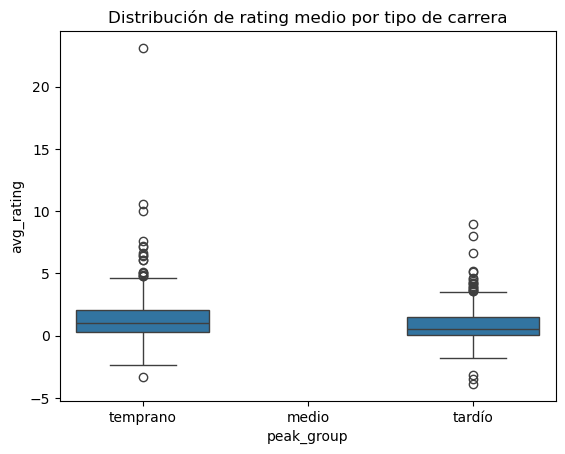

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribución de rating medio por grupo
model_df['peak_group'] = model_df['peak_group'].astype(str)
sns.boxplot(data=model_df, x='peak_group', y='avg_rating', order=['temprano', 'medio', 'tardío'])
plt.title("Distribución de rating medio por tipo de carrera")
plt.show()


# ETAPA 7 — Separación de datos por jugador

Para evitar fugas de información, usamos `train_test_split` por jugador. Esto garantiza que todos los datos de un jugador estén solo en entrenamiento o en test, pero nunca en ambos.

Además, codificamos las clases como enteros para modelos como CatBoost.


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Confirmamos que Player_ID es índice
model_df = pivot_combined.merge(peak_info[['Player_ID', 'peak_group']], on='Player_ID', how='inner')
model_df = model_df.set_index('Player_ID')

X = model_df.drop(columns=['peak_group'])
y = model_df['peak_group']

# Verificación
assert not any(X.index.duplicated()), "❌ ¡IDs duplicados en X!"
assert not any(y.index.duplicated()), "❌ ¡IDs duplicados en y!"

train_ids, test_ids = train_test_split(
    y.index, test_size=0.2, random_state=42, stratify=y
)

X_train = X.loc[train_ids]
X_test = X.loc[test_ids]
y_train = y.loc[train_ids]
y_test = y.loc[test_ids]





# ETAPA 8 — Entrenamiento final con CatBoost optimizado

Utilizamos más iteraciones y early stopping para mejorar rendimiento. También aplicamos `auto_class_weights='Balanced'` para evitar sesgo hacia clases mayoritarias.




In [69]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [70]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=700,
    learning_rate=0.03,
    depth=6,
    loss_function='Logloss',
    auto_class_weights='Balanced',
    early_stopping_rounds=50,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train, y_train_encoded, eval_set=(X_test, y_test_encoded))



# ETAPA 9 — Evaluación final: Accuracy, Kappa, MCC y matriz de confusión

Medimos el rendimiento general y clase por clase para validar la calidad del modelo.


In [71]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef, classification_report

y_pred = cat_model.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred.flatten())

print("🔍 Accuracy:", accuracy_score(y_test, y_pred_labels))
print("🧠 Kappa:", cohen_kappa_score(y_test, y_pred_labels))
print("📈 MCC:", matthews_corrcoef(y_test, y_pred_labels))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_labels))



🔍 Accuracy: 0.5465116279069767
🧠 Kappa: 0.0910569105691057
📈 MCC: 0.09112568331805838

📊 Classification Report:
               precision    recall  f1-score   support

      tardío       0.58      0.56      0.57       138
    temprano       0.51      0.53      0.52       120

    accuracy                           0.55       258
   macro avg       0.55      0.55      0.55       258
weighted avg       0.55      0.55      0.55       258

